# Packages

In [1]:
import os
import sys
import torch
import numpy as np      
from netCDF4 import Dataset  
from scipy.ndimage import label
from skimage.transform import resize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np

# These are specific to Zambia

In [2]:
y_min, y_max = 580, 930
x_min, x_max = 1480, 1850

# Crop geo coordinates

In [3]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max, x_min:x_max]
lats = geodata["lat"][y_min:y_max, x_min:x_max]

In [4]:
CONTEXT_LAT_MIN = np.min(lats)
CONTEXT_LAT_MAX = np.max(lats)
CONTEXT_LON_MIN = np.min(lons)
CONTEXT_LON_MAX = np.max(lons)

In [5]:
print(CONTEXT_LAT_MIN, CONTEXT_LAT_MAX, CONTEXT_LON_MIN, CONTEXT_LON_MAX)

-18.414806 -7.9918404 21.167515 35.316326


In [6]:
lons.shape

(350, 370)

# Choose a file

In [7]:
data_path = "/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/raw"

In [8]:
20240228_1700

202402281700

In [ ]:
year = "2024"
month = "02"
day = "28"
hour = "17"
minute = "00"

In [10]:
t_0 = f"{year}{month}{day}_{hour}{minute}.pt"

lead_time = 0

In [11]:
input_filename = f"{data_path}/inputs_t0/input-{t_0}"

output_filename = f"{data_path}/targets_t{lead_time}/target-{t_0}"

In [12]:
input_data = torch.load(input_filename)["input_tensor"]
input_time = torch.load(input_filename)["nowcast_origin"]

In [13]:
output_data = torch.load(output_filename)["data"].numpy()

# Number of observed cores at time $t_0$

In [14]:
# Assuming input_data has shape (288, 10)
# 3 time steps × 96 cores each

lags = [0, 60, 120]  # minutes
for i, lag in enumerate(lags):
    start = i * 96
    end = (i + 1) * 96
    n_real = torch.sum(input_data[start:end, -2] == 1).item()
    print(f"Time lag {lag:>3} min → {n_real:2d} real cores, {96 - n_real:2d} padded")

Time lag   0 min →  4 real cores, 92 padded
Time lag  60 min →  5 real cores, 91 padded
Time lag 120 min → 10 real cores, 86 padded


# Plot target

In [ ]:


ax.set_extent([DISPLAY_LON_MIN, DISPLAY_LON_MAX, DISPLAY_LAT_MIN, DISPLAY_LAT_MAX], crs=ccrs.PlateCarree())

21.167515 35.316326 -18.414806 -7.9918404


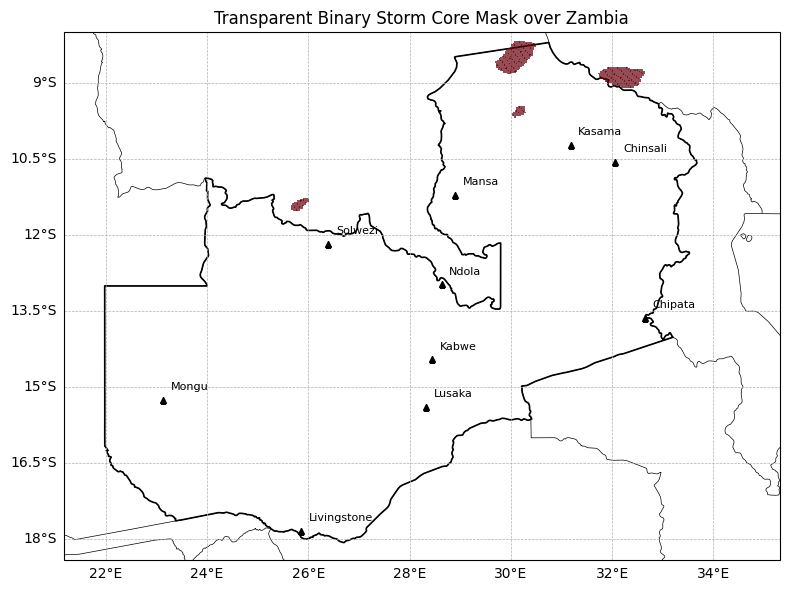

In [16]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent([CONTEXT_LON_MIN, CONTEXT_LON_MAX, CONTEXT_LAT_MIN, CONTEXT_LAT_MAX], crs=ccrs.PlateCarree())

# Base features (no fill to keep transparency)
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='none', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m', category='cultural', name=shapename)

# Plot Zambia outline only
for country in shpreader.Reader(countries_shp).records():
    if country.attributes['ADMIN'] == 'Zambia':
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor='none', edgecolor='black', linewidth=1.2, zorder=2)

# Locations
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

# Plot city markers
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=5,
            transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.15, lat + 0.15, name, fontsize=8,
            transform=ccrs.PlateCarree(), ha='left', va='bottom', color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=1, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False

# --- Plot the binary storm core mask ---
# Ensure output_data is binary (0 or 1)
# e.g., output_data = (cores != 0).astype(int)

# Mask zeros to make them transparent
masked_output = np.ma.masked_where(output_data == 0, output_data)

# Plot only the "blobs" (value == 1)
contour_core = ax.pcolormesh(
    lons, lats, masked_output,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.Reds,
    vmin=0, vmax=1,
    alpha=0.7,  # adjust opacity as you like
    zorder=2
)

plt.title("Transparent Binary Storm Core Mask over Zambia", fontsize=12)
plt.tight_layout()
plt.show()


In [17]:
output_data.shape

(350, 370)

In [18]:
from scipy.ndimage import label

In [19]:
labeled_array, _ = label(output_data != 0)
core_labels = np.unique(labeled_array[labeled_array != 0])

In [20]:
len(core_labels)

4

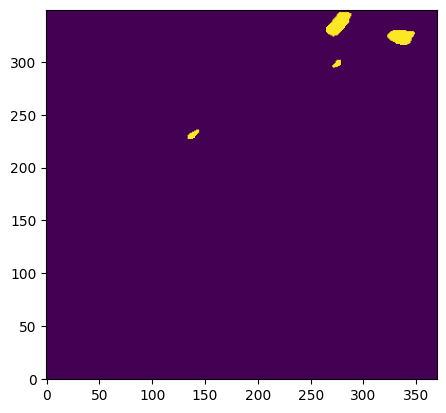

In [21]:
plt.imshow(output_data, origin='lower')